# Chapter 8 
 Industrial Statistics: A Computer Based Approach with Python<br>
by Ron Kenett, Shelemyahu Zacks, Peter Gedeck

Publisher: Springer International Publishing; 1st edition (2023) <br>
<!-- ISBN-13: 978-3031075650 -->

(c) 2022 Ron Kenett, Shelemyahu Zacks, Peter Gedeck

The code needs to be executed in sequence.

In [1]:
import os
os.environ['OUTDATED_IGNORE'] = '1'
import warnings
from outdated import OutdatedPackageWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=OutdatedPackageWarning)

# Cybermanufacturing and Digital Twins

In [2]:
import mistat
import matplotlib.pyplot as plt
import numpy as np

## Introduction to Cybermanufacturing

## Cybermanufacturing Analytics

## Information Quality in Cybermanufacturing

### Bayesian Networks

### CUB Models

### Control Charts

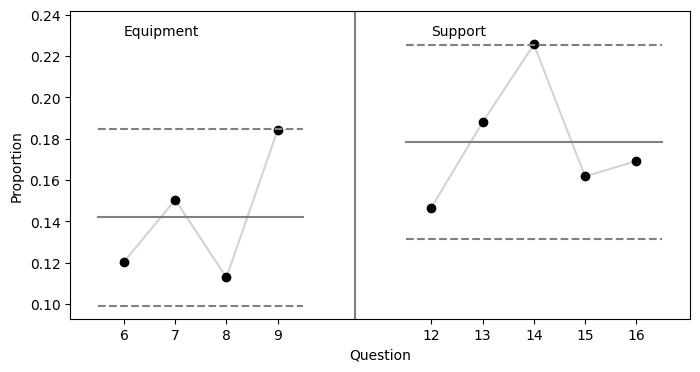

In [3]:
abc = mistat.load_data('ABC')
equipment = ['q6', 'q7', 'q8', 'q9']
support = ['q12', 'q13', 'q14', 'q15', 'q16']
top5counts = (abc[equipment + support] == 5).sum()

qcc1 = mistat.QualityControlChart(top5counts[equipment], qcc_type='np',
                                 sizes=len(abc), nsigmas=2)
qcc2 = mistat.QualityControlChart(top5counts[support], qcc_type='np',
                                 sizes=len(abc), nsigmas=2)

qcc1.data = qcc1.data / len(abc)
qcc1.center = qcc1.center / len(abc)
qcc1.limits = qcc1.limits / len(abc)
qcc2.data = qcc2.data / len(abc)
qcc2.center = qcc2.center / len(abc)
qcc2.limits = qcc2.limits / len(abc)

fig, ax = plt.subplots(figsize=(8, 4))
subsets = [
    {'x': np.array(range(6, 10)), 'qcc': qcc1},
    {'x': np.array(range(12, 17)), 'qcc': qcc2 },
]
for subset in subsets:
    qcc = subset['qcc']
    x = subset['x']
    ax.plot(x, qcc.data.values, color='lightgrey',
            marker='o', markeredgecolor='black', markerfacecolor='black')
    ax.plot((np.min(x)-0.5, np.max(x)+0.5), (qcc.center, qcc.center),
            color='grey')
    for limit in qcc.limits.values:
        ax.plot((np.min(x)-0.5, np.max(x)+0.5), (limit, limit),
            color='grey', ls='--')
ax.set_xticks(np.concatenate([subsets[0]['x'], subsets[1]['x']]))
ax.set_xlabel('Question')
ax.set_ylabel('Proportion')
ax.axvline(10.5, color='gray')
ax.text(6, 0.23, 'Equipment')
ax.text(12, 0.23, 'Support')
ylim = list(ax.get_ylim())
ylim[1] = ylim[1] + 0.01
ax.set_ylim(ylim)

plt.show()

## Modeling in Cybermanufacturing

## Computational pipelines

## Digital Twins

## Chapter Highlights

## Exercises